In [1]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
import seaborn as sns
sns.set()

%matplotlib inline

In [2]:
df = pd.read_csv('../crawler/dataset.csv')
df.head(10)

,title,category,description
0,Notebook Acer Aspire 5 A515-52-56A8 Intel Core...,Notebook,Cor Prata (partes A e C). Preto (partes B e D)...
1,Notebook Acer Aspire 5 A515-52G-522Z Intel Cor...,Notebook,Aspire 5 A515-52G-522Z - Processador Intel® Co...
2,Tela P/ Notebook Acer Aspire Es1-431-P0v7 14”...,Notebook,Enviamos Sua Tela Para Notebook Acer Aspire E...
3,Notebook Lenovo B330s-15ikbr Core I5 8250u 8gb...,Notebook,Lenovo B330s acessível e confiável. Acabament...
4,"Notebook Lenovo Ideapad 330 - Tela 15.6'' HD, ...",Notebook,alt='' style='width: 500px; height: 364px;'>
5,Teclado Notebook Acer Aspire E5-571,Notebook,Imagens meramente ilustrativas
6,GigabyteAorus 15,Notebook,» Valores deste anúncio exclusivamente para ...
7,Notebook Acer Aspire A515-51-C2TQ - Tela 15.6'...,Notebook,Dimensões do produto: 381.8 x 263 x 21.6 mm
8,GigabyteAorus 15,Notebook,» Valores deste anúncio exclusivamente para ...
9,Msigs65,Notebook,» Valores deste anúncio exclusivamente para ...


Each row of the dataset contains the **title, category and description**.

In [3]:
print('Approximate number of words in the dataset(non-unique): [%d]' %
      df['description'].apply(lambda x: len(x.split(' '))).sum())

Approximate number of words in the dataset(non-unique): [1975812]


Let's check the distribution of the classes.

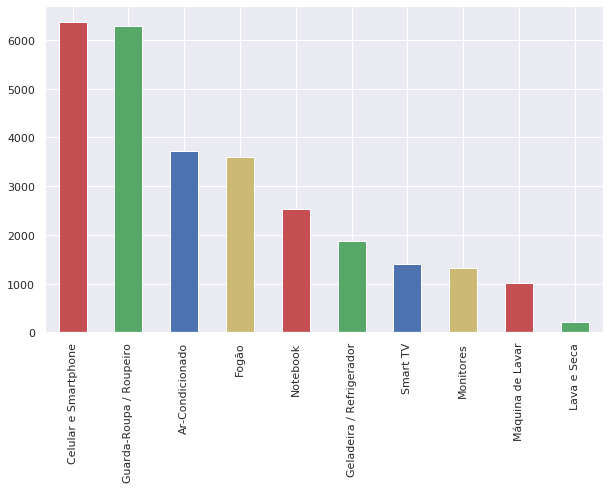

In [4]:
plt.figure(figsize=(10,6))
df.category.value_counts().plot(kind='bar', label='category', stacked=True, color=['r', 'g', 'b', 'y']);

As we can see the data is very unbalanced, so we are going to balance it using the class with minimum number of samples.

## Random under sampling approach

In [5]:
# Finding the minimum number of samples in the dataset
min_sample = min(df.category.value_counts())
print('Minimum number of samples: [%d]' % min_sample)

Minimum number of samples: [215]


In [6]:
balanced_under_df = pd.DataFrame()

categories = np.unique(df.category.values)

for category in categories:
    category_under = df[df['category'] == category].sample(min_sample, replace=True)
    print(len(category_under.values), category)
    balanced_under_df = pd.concat([balanced_under_df, category_under], axis=0)

215 Ar-Condicionado
215 Celular e Smartphone
215 Fogão
215 Geladeira / Refrigerador
215 Guarda-Roupa / Roupeiro
215 Lava e Seca
215 Monitores
215 Máquina de Lavar
215 Notebook
215 Smart TV


Now we have a balanced dataset over the categories collected.

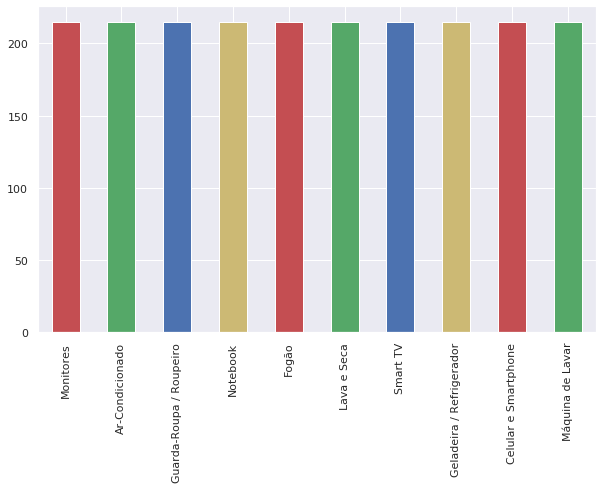

In [7]:
plt.figure(figsize=(10,6))
balanced_under_df.category.value_counts().plot(kind='bar', label='category', stacked=True, color=['r', 'g', 'b', 'y']);

## 2. Cleaning the data

In [8]:
from nltk.stem.rslp import RSLPStemmer
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('portuguese'))
# stemmer for portugues language
stemmer = RSLPStemmer()

punctuation = """\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?[\]\^\_\`\{\|\}~"""

# Defining cleaning regexes
number_re = re.compile(r'(\d+)', re.I | re.M | re.U)
punkt_re = re.compile(r'([%s])' % punctuation, re.I | re.M | re.U)
whitespaces_re = re.compile(r'(\s)', re.I | re.M | re.U)
terms_re = re.compile(r'(garantia|fornecedor|frete|meses|desconto)', re.I | re.M | re.U)


def clean_data(text, stem=False):
    """
        text: a string

        return: modified initial string
    """
    if type(text) != str:
        raise Exception('Doc is not text data')

    # Making a copy of the original textument
    _text = text

    # Stripping
    _text = _text.strip()

    # lower case
    _text = _text.lower()

    # removing numbers
    _text = number_re.sub('', _text)
    
    # removing context terms
    _text = terms_re.sub('', _text)

    # removing long white spaces to single space
    _text = whitespaces_re.sub(' ', _text)

    # Removing stopwords and words that aren't four units long
    tokens = [
        token for token in word_tokenize(_text)
        if (token not in stop_words and len(token) > 4 and '\\' not in token)
    ]
    if stem:
        _text = ' '.join([stemmer.stem(word) for word in tokens])
    else:
        _text = ' '.join([word for word in tokens])

    return _text

In [9]:
# Merging the two text data into one so we have all the descriptive text that defines a category
balanced_under_df['text'] = balanced_under_df['title'] + ' ' + balanced_under_df['description']
# cleaning the new text data
balanced_under_df.text = balanced_under_df.text.apply(clean_data, stem=False)


Data example below

In [10]:
balanced_under_df.text

21004    ar-condicionado split inverter ar-condicionado...
16391    condicionado split komeco condicionado split k...
21959    condicionado split inverter garden quente/frio...
16321    condicionado janela springer midea mecânico mc...
20805    condicionado split digital quente samsung cond...
                               ...                        
19637      televisor smart smart preços super competitivos
19679    smart samsung series descrição desfrute nível ...
27485    philco android curve phadsgwa philco android c...
20329    smart wi-fi momentos frente mesmos smart s/g.e...
20315    smart samsung qnqragxzd pontos quânticos ambie...
Name: text, Length: 2150, dtype: object

In [11]:
print('Number of words after pre-processing: [%d]' %
      balanced_under_df['text'].apply(lambda x: len(x.split(' '))).sum())

Number of words after pre-processing: [78527]


# Classification Models

## Multinomial Naive Bayes

### The Algorithm
The algorithm it is very statistical based using prior and posterior probabilities of the classes in the dataset.

Using the Bayes' Theorem below as the main idea:

$$P(A | B)P(B) = P(A \cap B) = P(B \cap A) = P(B | A)P(A)$$

$$P(A | B) = \frac{P(B | A)P(A)}{P(B)}$$


Now using the theorem we can ask what is the probability of a given class given that a specific document happened.

$$p(\text{class} \mid \mathbf {\text{data}} )={\frac {p(\mathbf {\text{data}} \mid \text{class}) * p(\text{class})}{p(\mathbf {\text{data}} )}}$$

where:


* $p(class | data)$ is called the posterior.
* $p(data | class)$ is called the likelihood.
* $p(class)$ is called the prior.
* $p(data)$ is called the marginal probability.


The equation above describes the full Bayes algorithm but some probabilites are very non pratical to calculate an example of this is the $P(data)$ because if we have a never seen document in the dataset this $P(data)$ is going to be $0$, so usually we don't calculate the marginal probabilities in real word cases.






**The term Naive comes from assuming that the variables are independent of each other when they may not be**

**The Multinomial is because we are not using the standard gaussian distribution but the multinomial distribution to calculate the likelihood probabilities**

This classifier is good for cases where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice.

Under sampling results

In [12]:
X = balanced_under_df.text
y = balanced_under_df.category

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=97)

The next steps includes feature engineering. We will convert our text documents to a matrix of token counts (CountVectorizer), then transform a count matrix to a normalized tf-idf representation (tf-idf transformer). After that, we train several classifiers.

In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [14]:
%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=categories))

accuracy 0.9426356589147287
                          precision    recall  f1-score   support

         Ar-Condicionado       0.95      0.98      0.97        58
    Celular e Smartphone       0.95      0.95      0.95        63
                   Fogão       0.99      0.99      0.99        68
Geladeira / Refrigerador       1.00      0.95      0.97        74
 Guarda-Roupa / Roupeiro       0.97      1.00      0.98        58
             Lava e Seca       0.86      0.76      0.81        55
               Monitores       0.95      0.97      0.96        71
        Máquina de Lavar       0.79      0.91      0.85        55
                Notebook       0.98      0.94      0.96        68
                Smart TV       0.96      0.95      0.95        75

                accuracy                           0.94       645
               macro avg       0.94      0.94      0.94       645
            weighted avg       0.94      0.94      0.94       645

CPU times: user 24.5 ms, sys: 2.52 ms, total: